<a href="https://colab.research.google.com/github/thaone31/VietnameseHotelSentimentNLP/blob/main/PhoBert_with_LSTM%2C_CNN%2C_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Install libraries***

In [ ]:
# load pre-trained BERT và tune
!pip install transformers
!pip install fastBPE
!pip install fairseq

  Preparing metadata (setup.py) ... done
  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp310-cp310-linux_x86_64.whl size=806623 sha256=6c0346028edac4233516fe60f6bc927b2e7566badb2f438b5ac827d236650f4a
  Stored in directory: /root/.cache/pip/wheels/13/5d/b9/4b8897941ebc9e8c6cc3f3ffd3ea5115731754269205098754
Successfully built fastBPE
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 25.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.7/288.7 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fairseq: f

In [ ]:
# Thư viện vncorenlp và wordsegmenter dùng để Word Segmentation cho tiếng Việt

# Install the vncorenlp python wrapper
!pip install vncorenlp

!pip install pydot
!pip install graphviz

# Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter)
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645932 sha256=bbd87e464e74e5f8a6505d4d4d08acb3793787e2593589c00673cf04003e9d55
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp
--2023-12-31 17:44:37--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M   144MB/s    in 0.2s    

2023-12-31 17:44:38 (144 MB/s) - ‘VnCoreNLP

In [ ]:
# Tải về bộ dữ liệu huấn luyện từ trang chủ cuộc thi của AIVIVN và
# pre-trained của PhoBERT xong tiến hành giải nén

!wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
!tar -xzvf PhoBERT_base_transformers.tar.gz

--2023-12-31 17:44:39--  https://public.vinai.io/PhoBERT_base_transformers.tar.gz
Resolving public.vinai.io (public.vinai.io)... 13.225.142.12, 13.225.142.107, 13.225.142.7, ...
Connecting to public.vinai.io (public.vinai.io)|13.225.142.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322405979 (307M) [application/x-tar]
Saving to: ‘PhoBERT_base_transformers.tar.gz’

PhoBERT_base_transf 100%[===================>] 307.47M   238MB/s    in 1.3s    

2023-12-31 17:44:41 (238 MB/s) - ‘PhoBERT_base_transformers.tar.gz’ saved [322405979/322405979]

PhoBERT_base_transformers/
PhoBERT_base_transformers/config.json
PhoBERT_base_transformers/bpe.codes
PhoBERT_base_transformers/model.bin
PhoBERT_base_transformers/dict.txt


# ***Import libraries***

In [ ]:
import os
import torch
import pickle
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from vncorenlp import VnCoreNLP
import argparse
from fairseq.data import Dictionary
from fairseq.data.encoders.fastbpe import fastBPE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score

from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#import drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***Load Data and Pre-process***

In [ ]:
# tạo bộ word segmentation cho tiếng Việt
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [ ]:
# load model và bpe lên theo hướng dẫn của PhoBERT
parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes',
    default="./PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,
    help='path to fastBPE BPE'
)
args, unknown = parser.parse_known_args()
bpe = fastBPE(args)

# Load the dictionary
vocab = Dictionary()
vocab.add_from_file("./PhoBERT_base_transformers/dict.txt")

In [ ]:
# lấy đường dẫn của file Train và file Test
path_train = '/content/drive/MyDrive/NCKHSV2023-2024/Bản sao của train.xlsx'
path_test = '/content/drive/MyDrive/NCKHSV2023-2024/Bản sao của test.xlsx'

In [ ]:
import os
import pandas as pd

# Function to read an xlsx file
# Input: file path
# Output: DataFrame containing the file data
def read_xlsx(path):
    try:
        data = pd.read_excel(path, engine='openpyxl')
    except:
        data = pd.DataFrame()
    return data


# Function to extract the contents, titles, and ratings from the xlsx file
# Input: path to the folder (Train or Test)
# Output: the contents, titles, and ratings
def make_data(file_path):
    titles = []
    texts = []
    ratings = []

    data = read_xlsx(file_path)
    if data.empty:
        return titles, texts, ratings

    for index, row in data.iterrows():
        title = row['title']
        text = row['text']
        rating = row['rating']

        # Processing the content, title, and rating if needed
        # ...

        titles.append(title)
        texts.append(text)
        ratings.append(rating)

    return titles, texts, ratings

In [ ]:
train_titles, train_texts, train_ratings = make_data(path_train)
test_titles, test_texts, test_ratings = make_data(path_test)

print(len(train_texts), len(train_titles), len(train_ratings))
print(len(test_texts), len(test_titles), len(test_ratings))

6723 6723 6723
1681 1681 1681


In [ ]:
train_titles[0], train_texts[0], train_ratings[0]

('resort ổn cho các chuyển đi Gia Đình',
 'resort sạch sẽ, phục vụ nhanh , chuyên nghiệp. Nhiều bể bơi lớn nhưng luôn đảm bảo lực lượng bảo vệ cứu hộ sẵn sàng nên rất yên tâm khi đi cùng trẻ nhỏ. Các hoạt động ở resort khá đa dạng, đáp ứng được nhiều lứa tuổi nên đây là 1 lựa chọn ổn khi đi du lịch gia đình cùng người già và trẻ nhỏ,',
 4)

In [ ]:
# label encoded
lb_encoder = LabelEncoder()
lb_encoder.fit(train_ratings)

en_train_labels = lb_encoder.transform(train_ratings)
en_test_labels = lb_encoder.transform(test_ratings)

print(lb_encoder.classes_)  # in kiểm tra các labels

[1 2 3 4 5]


In [ ]:
from sklearn.model_selection import train_test_split

train_sent_titles, val_sent_titles, train_sent_texts, val_sent_texts, train_ratings, val_ratings = train_test_split(train_titles, train_texts, en_train_labels, test_size=0.1)
print(len(train_sent_texts), len(val_sent_texts))
print(len(train_sent_titles), len(val_sent_titles))

6050 673
6050 673


In [ ]:
MAX_LEN = 256

def convert_sents_ids(sents):
    ids = []
    for sent in sents:
        sent = str(sent)
        subwords = '<s> ' + bpe.encode(sent) + ' </s>'
        encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
        ids.append(encoded_sent)
    ids = pad_sequences(ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
    return torch.tensor(ids)

train_title_ids = convert_sents_ids(train_sent_titles)
train_text_ids = convert_sents_ids(train_sent_texts)
val_title_ids = convert_sents_ids(val_sent_titles)
val_text_ids = convert_sents_ids(val_sent_texts)
test_title_ids = convert_sents_ids(test_titles)
test_text_ids = convert_sents_ids(test_texts)

In [ ]:
def make_mask(batch_ids):
    batch_mask = []
    for ids in batch_ids:
        mask = [int(token_id > 0) for token_id in ids]
        batch_mask.append(mask)
    return torch.tensor(batch_mask)

train_title_masks = make_mask(train_title_ids)
train_text_masks = make_mask(train_text_ids)

val_title_masks = make_mask(val_title_ids)
val_text_masks = make_mask(val_text_ids)

test_title_masks = make_mask(test_title_ids)
test_text_masks = make_mask(test_text_ids)

In [ ]:
def make_data_loader(ids, masks, BATCH_SIZE=4):
    data = TensorDataset(ids, masks)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=BATCH_SIZE)
    return dataloader

train_labels = torch.tensor(train_ratings)
val_labels = torch.tensor(val_ratings)
test_labels = torch.tensor(en_test_labels)

train_title_dataloader = make_data_loader(train_title_ids, train_title_masks)
train_text_dataloader = make_data_loader(train_text_ids, train_text_masks)

val_title_dataloader = make_data_loader(val_title_ids, val_title_masks)
val_text_dataloader = make_data_loader(val_text_ids, val_text_masks)

test_title_dataloader = make_data_loader(test_title_ids, test_title_masks)
test_title_dataloader = make_data_loader(test_text_ids, test_text_masks)


# ***Model LSTM***

In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(train_labels)
y_val = to_categorical(val_labels)

In [ ]:
EPOCHS = 100

In [ ]:
from keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate
from keras.models import Model

vocab_size = len(vocab)
embedding_dim = 128
hidden_size = 256

# Đầu vào cho title
title_input = Input(shape=(train_title_ids.shape[1],))
title_embedding = Embedding(vocab_size, embedding_dim, input_length=train_title_ids.shape[1])(title_input)
title_lstm = LSTM(hidden_size, return_sequences=True)(title_embedding)
title_lstm_dropout = Dropout(0.2)(title_lstm)
title_lstm_final = LSTM(hidden_size)(title_lstm_dropout)

# Đầu vào cho text
text_input = Input(shape=(train_text_ids.shape[1],))
text_embedding = Embedding(vocab_size, embedding_dim, input_length=train_text_ids.shape[1])(text_input)
text_lstm = LSTM(hidden_size, return_sequences=True)(text_embedding)
text_lstm_dropout = Dropout(0.2)(text_lstm)
text_lstm_final = LSTM(hidden_size)(text_lstm_dropout)

# Kết hợp hai đầu vào
combined = concatenate([title_lstm_final, text_lstm_final])

# Các bước còn lại của mô hình
dense1 = Dense(128, activation='relu')(combined)
output = Dense(y_train.shape[1], activation='softmax')(dense1)

# Xây dựng mô hình
model_LSTM = Model(inputs=[title_input, text_input], outputs=output)

model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 256, 128)             8192000   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 256, 128)             8192000   ['input_2[0][0]']             
                                                                                              

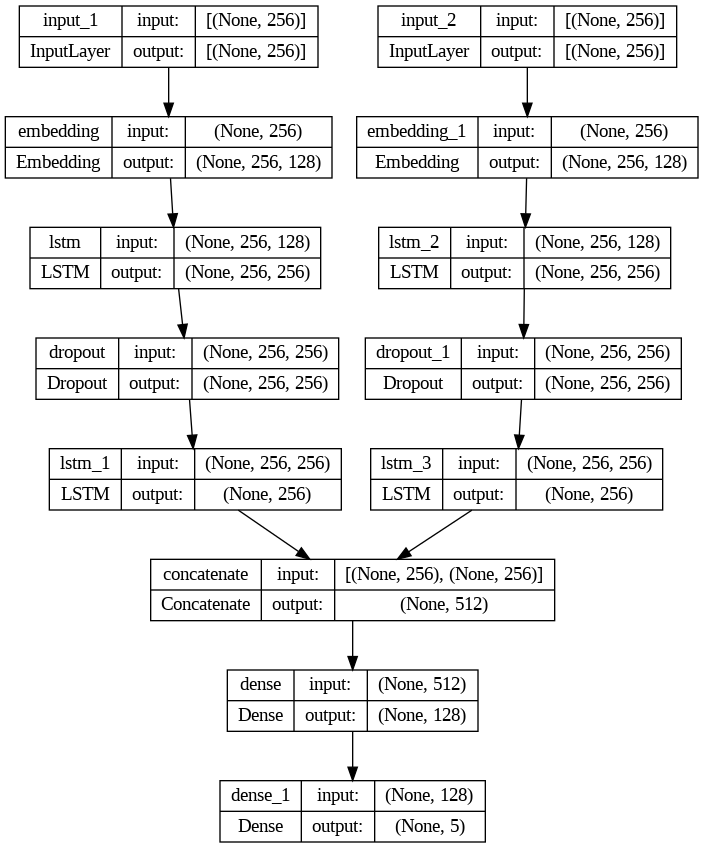

In [ ]:
from keras.utils import plot_model

plot_model(model_LSTM, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_LSTM_history = model_LSTM.fit(
    [np.array(train_title_ids), np.array(train_text_ids)],
    y_train,
    epochs=EPOCHS,
    batch_size=4,
    verbose=1,
    validation_data=([np.array(val_title_ids), np.array(val_text_ids)], y_val)
)

Epoch 1/20
1513/1513 [==============================] - 148s 87ms/step - loss: 0.7472 - accuracy: 0.7716 - val_loss: 0.7831 - val_accuracy: 0.7578
Epoch 2/20
1513/1513 [==============================] - 88s 58ms/step - loss: 0.7275 - accuracy: 0.7747 - val_loss: 0.7914 - val_accuracy: 0.7578
Epoch 3/20
1513/1513 [==============================] - 93s 61ms/step - loss: 0.7260 - accuracy: 0.7747 - val_loss: 0.7914 - val_accuracy: 0.7578
Epoch 4/20
1513/1513 [==============================] - 94s 62ms/step - loss: 0.7241 - accuracy: 0.7747 - val_loss: 0.7870 - val_accuracy: 0.7578
Epoch 5/20
1513/1513 [==============================] - 86s 57ms/step - loss: 0.7230 - accuracy: 0.7747 - val_loss: 0.7843 - val_accuracy: 0.7578
Epoch 6/20
1513/1513 [==============================] - 85s 56ms/step - loss: 0.7243 - accuracy: 0.7747 - val_loss: 0.7879 - val_accuracy: 0.7578
Epoch 7/20
1513/1513 [==============================] - 83s 55ms/step - loss: 0.7218 - accuracy: 0.7747 - val_loss: 0.7730 

In [ ]:
# Dự đoán trên tập validation
val_pred = model_LSTM.predict([np.array(val_title_ids), np.array(val_text_ids)])

# Chuyển đổi dự đoán về dạng categorical
val_pred_categorical = np.argmax(val_pred, axis=1)

# Tính các metrics
report = classification_report(np.argmax(y_val, axis=1), val_pred_categorical)
print(report)


22/22 [==============================] - 1s 28ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        42
           3       0.00      0.00      0.00       107
           4       0.76      1.00      0.86       510

    accuracy                           0.76       673
   macro avg       0.15      0.20      0.17       673
weighted avg       0.57      0.76      0.65       673



In [ ]:
model_LSTM.save_weights('/content/drive/MyDrive/NCKHSV2023-2024/LSTM_text_classification.h5')

***Evaluate on Test folder***

In [ ]:
# xây dựng hàm đánh giá
def test_LSTM(X_test, y_test):
    y_pred = model_LSTM.predict(X_test)
    pred = np.argmax(y_pred,axis=1)

    print(classification_report(y_test, pred))

# đánh giá trên tập test
test_LSTM([np.array(test_title_ids), np.array(test_text_ids)], np.array(test_labels))

53/53 [==============================] - 2s 31ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00       280
           4       0.77      1.00      0.87      1290

    accuracy                           0.77      1681
   macro avg       0.15      0.20      0.17      1681
weighted avg       0.59      0.77      0.67      1681



# ***CNN***

In [ ]:
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, concatenate
from keras.models import Model

vocab_size = len(vocab)
embedding_dim = 128
num_filters = 128
filter_sizes = [3, 4, 5]

# Input for title
title_input = Input(shape=(train_title_ids.shape[1],))
title_embedding = Embedding(vocab_size, embedding_dim, input_length=train_title_ids.shape[1])(title_input)
title_conv_blocks = []
for filter_size in filter_sizes:
    title_conv = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu')(title_embedding)
    title_pool = MaxPooling1D(pool_size=train_title_ids.shape[1] - filter_size + 1)(title_conv)
    title_conv_blocks.append(title_pool)
title_concat = concatenate(title_conv_blocks, axis=-1)
title_flat = Flatten()(title_concat)

# Input for text
text_input = Input(shape=(train_text_ids.shape[1],))
text_embedding = Embedding(vocab_size, embedding_dim, input_length=train_text_ids.shape[1])(text_input)
text_conv_blocks = []
for filter_size in filter_sizes:
    text_conv = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu')(text_embedding)
    text_pool = MaxPooling1D(pool_size=train_text_ids.shape[1] - filter_size + 1)(text_conv)
    text_conv_blocks.append(text_pool)
text_concat = concatenate(text_conv_blocks, axis=-1)
text_flat = Flatten()(text_concat)

# Combine the two inputs
combined = concatenate([title_flat, text_flat])

# Additional layers of the model
dense1 = Dense(128, activation='relu')(combined)
output = Dense(y_train.shape[1], activation='softmax')(dense1)

# Build the model
model_CNN = Model(inputs=[title_input, text_input], outputs=output)

model_CNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_CNN.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 256, 128)             8192000   ['input_3[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 256, 128)             8192000   ['input_4[0][0]']             
                                                                                            

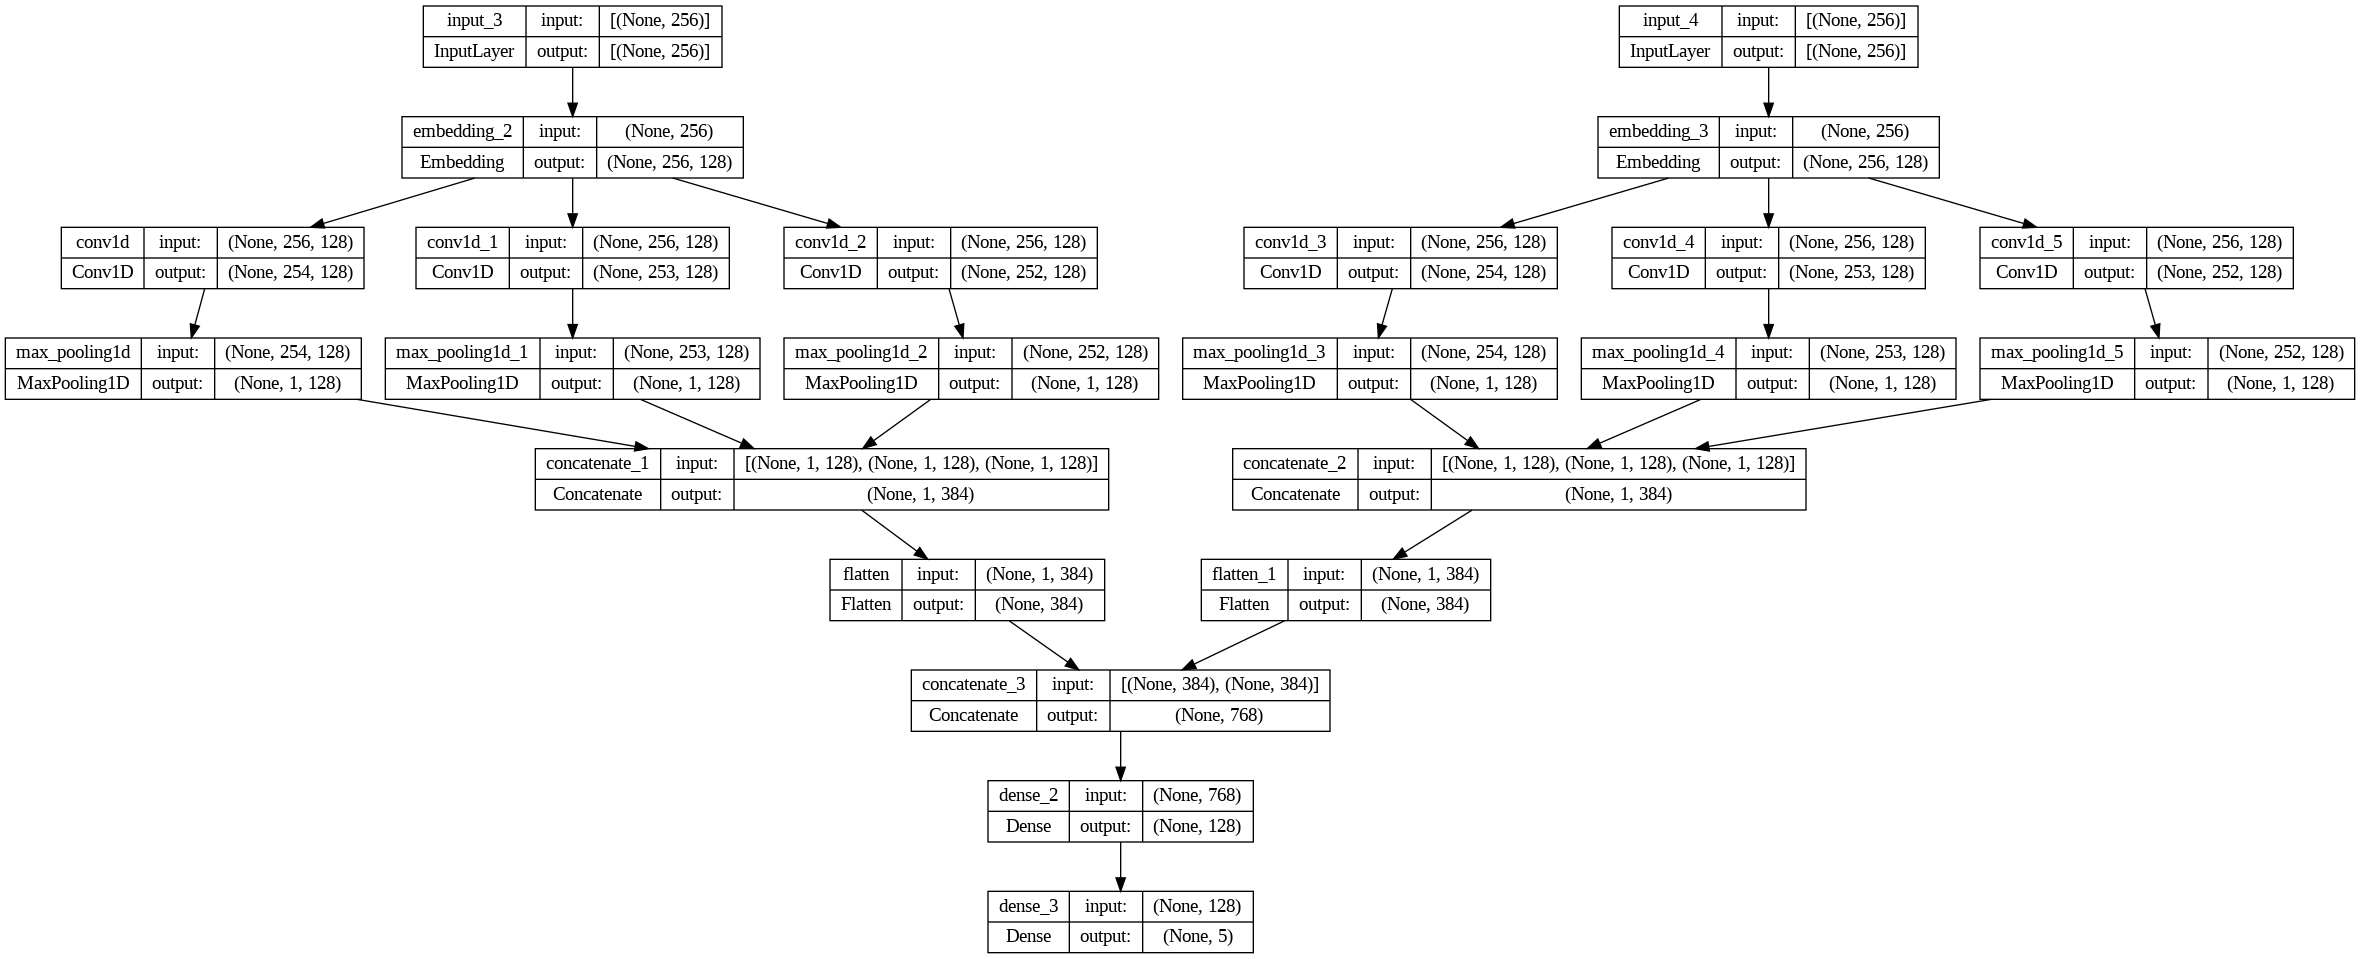

In [ ]:
from keras.utils import plot_model

plot_model(model_CNN, to_file='modelCNN.png', show_shapes=True, show_layer_names=True)

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
    history = model.fit(
        [X_train['title'], X_train['text']],
        y_train,
        validation_data=([X_val['title'], X_val['text']], y_val),
        epochs=epochs,
        batch_size=batch_size
    )
    return history

In [ ]:
history = model_CNN.fit(
    [np.array(train_title_ids), np.array(train_text_ids)],
    y_train,
    epochs=EPOCHS,
    batch_size=4,
    verbose=1,
    validation_data=([np.array(val_title_ids), np.array(val_text_ids)], y_val)
)

Epoch 1/20
1513/1513 [==============================] - 54s 33ms/step - loss: 0.5216 - accuracy: 0.8071 - val_loss: 0.5294 - val_accuracy: 0.8009
Epoch 2/20
1513/1513 [==============================] - 19s 13ms/step - loss: 0.3412 - accuracy: 0.8661 - val_loss: 0.5862 - val_accuracy: 0.7935
Epoch 3/20
1513/1513 [==============================] - 18s 12ms/step - loss: 0.2165 - accuracy: 0.9183 - val_loss: 0.6321 - val_accuracy: 0.7949
Epoch 4/20
1513/1513 [==============================] - 18s 12ms/step - loss: 0.1205 - accuracy: 0.9588 - val_loss: 0.8090 - val_accuracy: 0.7920
Epoch 5/20
1513/1513 [==============================] - 17s 11ms/step - loss: 0.0840 - accuracy: 0.9691 - val_loss: 0.9631 - val_accuracy: 0.7935
Epoch 6/20
1513/1513 [==============================] - 18s 12ms/step - loss: 0.0645 - accuracy: 0.9769 - val_loss: 1.1553 - val_accuracy: 0.7920
Epoch 7/20
1513/1513 [==============================] - 18s 12ms/step - loss: 0.0522 - accuracy: 0.9826 - val_loss: 1.3930 -

In [ ]:
from sklearn.metrics import classification_report

# Dự đoán trên tập validation
val_pred = model_CNN.predict([np.array(val_title_ids), np.array(val_text_ids)])

# Chuyển đổi dự đoán về dạng categorical
val_pred_categorical = np.argmax(val_pred, axis=1)

# Tính các metrics
report = classification_report(np.argmax(y_val, axis=1), val_pred_categorical)
print(report)


22/22 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.14      0.12      0.13         8
           2       0.50      0.40      0.45        42
           3       0.49      0.61      0.54       107
           4       0.91      0.88      0.90       510

    accuracy                           0.80       673
   macro avg       0.57      0.54      0.55       673
weighted avg       0.81      0.80      0.80       673



In [ ]:
model_CNN.save_weights('/content/drive/MyDrive/NCKHSV2023-2024/CNN_text_classification.h5')

***Evaluate on Test fold***

In [ ]:
# xây dựng hàm đánh giá
def test_CNN(X_test, y_test):
    y_pred = model_CNN.predict(X_test)
    pred = np.argmax(y_pred,axis=1)

    print(classification_report(y_test, pred))

# đánh giá trên tập test
test_CNN([np.array(test_title_ids), np.array(test_text_ids)], np.array(test_labels))

53/53 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.29      0.14      0.19        14
           1       0.53      0.38      0.44        24
           2       0.54      0.53      0.54        73
           3       0.51      0.67      0.58       280
           4       0.92      0.87      0.89      1290

    accuracy                           0.81      1681
   macro avg       0.56      0.52      0.53      1681
weighted avg       0.82      0.81      0.81      1681



# ***BiLSTM***

In [ ]:
from keras.layers import Input, Bidirectional, LSTM, Dense, GlobalMaxPooling1D
from keras.models import Model

def build_bilstm_model():
    # Define input layers for the title and text inputs
    title_input = Input(shape=(train_title_ids.shape[1],))
    text_input = Input(shape=(train_text_ids.shape[1],))

    # Embedding layer for title
    title_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, trainable=True)(title_input)
    # Embedding layer for text
    text_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, trainable=True)(text_input)

    # Bidirectional LSTM layer for title
    title_bilstm = Bidirectional(LSTM(64, return_sequences=True))(title_embedding)
    # Bidirectional LSTM layer for text
    text_bilstm = Bidirectional(LSTM(64, return_sequences=True))(text_embedding)

    # Global Max Pooling layer for title
    title_pooling = GlobalMaxPooling1D()(title_bilstm)
    # Global Max Pooling layer for text
    text_pooling = GlobalMaxPooling1D()(text_bilstm)

    # Concatenate title and text pooling layers
    concatenated_pooling = concatenate([title_pooling, text_pooling])

    # Dense layer for final prediction
    output_layer = Dense(5, activation='softmax')(concatenated_pooling)

    # Create model
    model = Model(inputs=[title_input, text_input], outputs=output_layer)

    return model

# Build the BiLSTM model
model_BiLSTM = build_bilstm_model()
model_BiLSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_BiLSTM.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 256, 128)             8192000   ['input_9[0][0]']             
                                                                                                  
 embedding_7 (Embedding)     (None, 256, 128)             8192000   ['input_10[0][0]']            
                                                                                            

In [ ]:
model_BiLSTM.save_weights('/content/drive/MyDrive/NCKHSV2023-2024/BiLSTM_text_classification.h5')

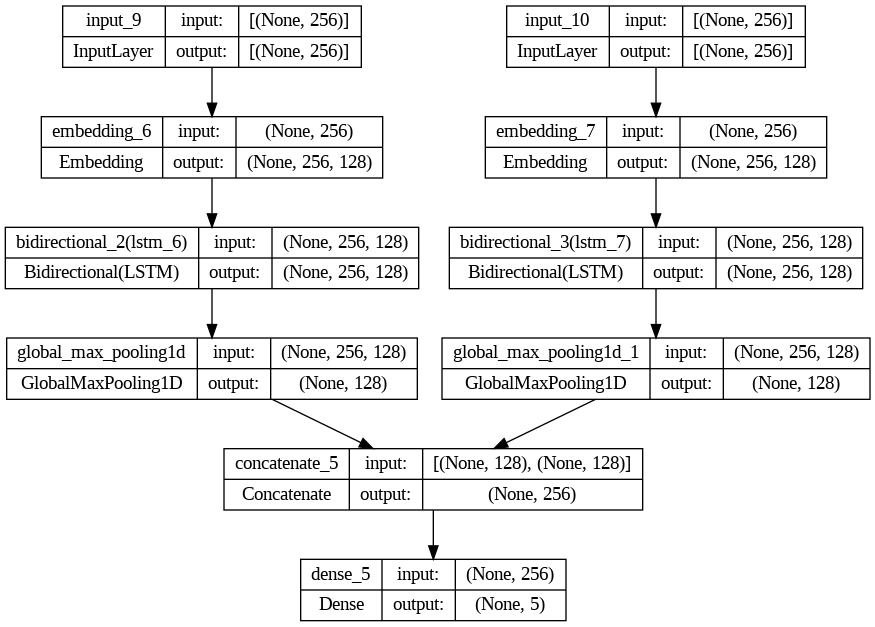

In [ ]:
from keras.utils import plot_model

plot_model(model_BiLSTM, to_file='modelBiLSTM.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model_BiLSTM.fit(
    [np.array(train_title_ids), np.array(train_text_ids)],
    y_train,
    epochs=EPOCHS,
    batch_size=4,
    verbose=1,
    validation_data=([np.array(val_title_ids), np.array(val_text_ids)], y_val)
)

Epoch 1/20
1513/1513 [==============================] - 96s 59ms/step - loss: 0.5345 - accuracy: 0.8003 - val_loss: 0.5120 - val_accuracy: 0.8143
Epoch 2/20
1513/1513 [==============================] - 62s 41ms/step - loss: 0.3653 - accuracy: 0.8575 - val_loss: 0.5417 - val_accuracy: 0.8262
Epoch 3/20
1513/1513 [==============================] - 58s 38ms/step - loss: 0.2700 - accuracy: 0.8969 - val_loss: 0.5959 - val_accuracy: 0.8098
Epoch 4/20
1513/1513 [==============================] - 58s 38ms/step - loss: 0.1908 - accuracy: 0.9281 - val_loss: 0.6557 - val_accuracy: 0.8024
Epoch 5/20
1513/1513 [==============================] - 59s 39ms/step - loss: 0.1306 - accuracy: 0.9519 - val_loss: 0.7899 - val_accuracy: 0.8009
Epoch 6/20
1513/1513 [==============================] - 57s 38ms/step - loss: 0.0899 - accuracy: 0.9686 - val_loss: 0.9037 - val_accuracy: 0.7979
Epoch 7/20
1513/1513 [==============================] - 56s 37ms/step - loss: 0.0675 - accuracy: 0.9757 - val_loss: 0.9241 -

In [ ]:
# Dự đoán trên tập validation
val_pred = model_BiLSTM.predict([np.array(val_title_ids), np.array(val_text_ids)])

# Chuyển đổi dự đoán về dạng categorical
val_pred_categorical = np.argmax(val_pred, axis=1)

# Tính các metrics
report = classification_report(np.argmax(y_val, axis=1), val_pred_categorical)
print(report)


22/22 [==============================] - 2s 20ms/step
              precision    recall  f1-score   support

           0       0.67      0.33      0.44         6
           1       0.00      0.00      0.00         8
           2       0.65      0.36      0.46        42
           3       0.43      0.44      0.44       107
           4       0.88      0.91      0.90       510

    accuracy                           0.79       673
   macro avg       0.53      0.41      0.45       673
weighted avg       0.78      0.79      0.78       673



***Evaluate on Test folder***

In [ ]:
# xây dựng hàm đánh giá
def test_BiLSTM(X_test, y_test):
    y_pred = model_BiLSTM.predict(X_test)
    pred = np.argmax(y_pred,axis=1)

    print(classification_report(y_test, pred))

# đánh giá trên tập test
test_BiLSTM([np.array(test_title_ids), np.array(test_text_ids)], np.array(test_labels))

53/53 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.25      0.14      0.18        14
           1       0.74      0.58      0.65        24
           2       0.62      0.38      0.47        73
           3       0.50      0.54      0.51       280
           4       0.88      0.90      0.89      1290

    accuracy                           0.80      1681
   macro avg       0.60      0.51      0.54      1681
weighted avg       0.80      0.80      0.80      1681



# ***Ensemble Learning CNN+LSTM***

In [ ]:
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import backend as K

def build_ensemble_model(model_LSTM, model_CNN):
    # Define input layers for the title and text inputs
    title_input = Input(shape=(train_title_ids.shape[1],))
    text_input = Input(shape=(train_text_ids.shape[1],))

    # Get the LSTM and CNN predictions
    lstm_predictions = model_LSTM([title_input, text_input])
    cnn_predictions = model_CNN([title_input, text_input])

    # Select the predictions for labels 1 to 5
    lstm_selected = lstm_predictions[:, :5]
    cnn_selected = cnn_predictions[:, :5]

    # Concatenate the selected predictions
    concatenated_predictions = Concatenate()([lstm_selected, cnn_selected])

    # Calculate the average of concatenated predictions
    ensemble_predictions = Dense(5, activation='softmax')(concatenated_predictions)

    ensemble_model = Model(inputs=[title_input, text_input], outputs=ensemble_predictions)

    return ensemble_model

# Build the ensemble model
model_ensemble_cnn_lstm = build_ensemble_model(model_LSTM, model_CNN)
model_ensemble_cnn_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_ensemble_cnn_lstm.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 model (Functional)          (None, 5)                    1828941   ['input_5[0][0]',             
                                                          3          'input_6[0][0]']             
                                                                                                  
 model_1 (Functional)        (None, 5)                    1687706   ['input_5[0][0]',       

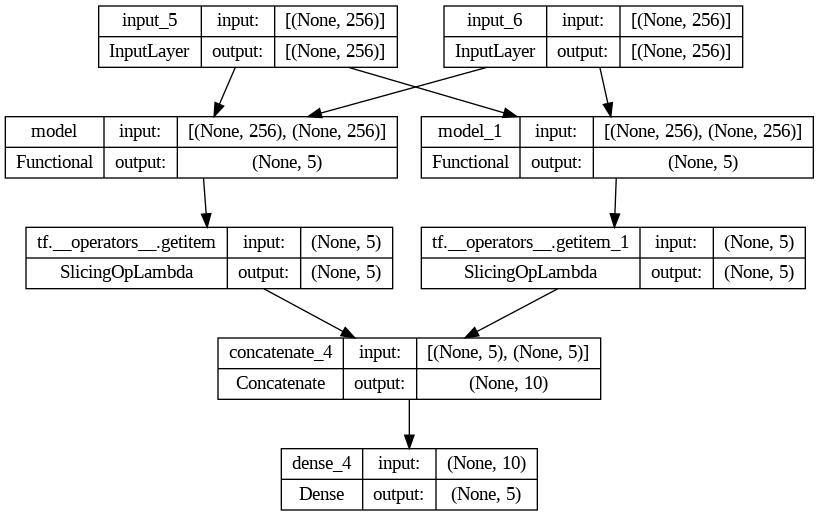

In [ ]:
from keras.utils import plot_model

plot_model(model_ensemble_cnn_lstm, to_file='modelensembleCNNlstm.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_ensemble_cnn_lstm.save_weights('/content/drive/MyDrive/NCKHSV2023-2024/LSTM_CNN_text_classification.h5')

In [ ]:
history = model_ensemble_cnn_lstm.fit(
    [np.array(train_title_ids), np.array(train_text_ids)],
    y_train,
    epochs=EPOCHS,
    batch_size=4,
    verbose=1,
    validation_data=([np.array(val_title_ids), np.array(val_text_ids)], y_val)
)

Epoch 1/20
1513/1513 [==============================] - 160s 99ms/step - loss: 0.5844 - accuracy: 0.8760 - val_loss: 0.7453 - val_accuracy: 0.7845
Epoch 2/20
1513/1513 [==============================] - 121s 80ms/step - loss: 0.3205 - accuracy: 0.9221 - val_loss: 0.7173 - val_accuracy: 0.7637
Epoch 3/20
1513/1513 [==============================] - 120s 79ms/step - loss: 0.3092 - accuracy: 0.9165 - val_loss: 0.7653 - val_accuracy: 0.7845
Epoch 4/20
1513/1513 [==============================] - 99s 65ms/step - loss: 0.2878 - accuracy: 0.9193 - val_loss: 0.7823 - val_accuracy: 0.7786
Epoch 5/20
1513/1513 [==============================] - 98s 65ms/step - loss: 0.2877 - accuracy: 0.9207 - val_loss: 0.7757 - val_accuracy: 0.7979
Epoch 6/20
1513/1513 [==============================] - 99s 65ms/step - loss: 0.2670 - accuracy: 0.9236 - val_loss: 0.7961 - val_accuracy: 0.7667
Epoch 7/20
1513/1513 [==============================] - 97s 64ms/step - loss: 0.2997 - accuracy: 0.9122 - val_loss: 0.757

In [ ]:
# Dự đoán trên tập validation
val_pred = model_ensemble_cnn_lstm.predict([np.array(val_title_ids), np.array(val_text_ids)])

# Chuyển đổi dự đoán về dạng categorical
val_pred_categorical = np.argmax(val_pred, axis=1)

# Tính các metrics
report = classification_report(np.argmax(y_val, axis=1), val_pred_categorical)
print(report)


22/22 [==============================] - 1s 33ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         8
           2       0.56      0.36      0.43        42
           3       0.49      0.58      0.53       107
           4       0.90      0.90      0.90       510

    accuracy                           0.80       673
   macro avg       0.39      0.37      0.37       673
weighted avg       0.80      0.80      0.80       673



***Evaluate on Test folder***

In [ ]:
# xây dựng hàm đánh giá
def test_LSTM_CNN(X_test, y_test):
    y_pred = model_ensemble_cnn_lstm.predict(X_test)
    pred = np.argmax(y_pred,axis=1)

    print(classification_report(y_test, pred))

# đánh giá trên tập test
test_LSTM_CNN([np.array(test_title_ids), np.array(test_text_ids)], np.array(test_labels))

53/53 [==============================] - 2s 29ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.56      0.58      0.57        24
           2       0.57      0.51      0.54        73
           3       0.50      0.55      0.52       280
           4       0.90      0.90      0.90      1290

    accuracy                           0.81      1681
   macro avg       0.51      0.51      0.51      1681
weighted avg       0.81      0.81      0.81      1681



# ***Ensemble Learning BiLSTM + CNN***

In [ ]:
from keras.layers import Input, concatenate, Dense, Concatenate, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D
from keras.models import Model
from keras import backend as K

def build_ensemble_model(model_BiLSTM, model_CNN):
    # Define input layers for the title and text inputs
    title_input = Input(shape=(train_title_ids.shape[1],))
    text_input = Input(shape=(train_text_ids.shape[1],))

    # Get the predictions from the BiLSTM model
    lstm_predictions = model_BiLSTM([title_input, text_input])

    # Get the predictions from the CNN model
    cnn_predictions = model_CNN([title_input, text_input])

    # Concatenate the predictions
    concatenated_predictions = Concatenate()([lstm_predictions, cnn_predictions])

    # Add a dense layer
    dense_layer = Dense(64, activation='relu')(concatenated_predictions)

    # Add another dense layer for the final output
    output_layer = Dense(5, activation='softmax')(dense_layer)

    ensemble_model = Model(inputs=[title_input, text_input], outputs=output_layer)

    return ensemble_model

# Build the ensemble model
model_ensemble_bilstm_cnn = build_ensemble_model(model_BiLSTM, model_CNN)
model_ensemble_bilstm_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ensemble_bilstm_cnn.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 model_3 (Functional)        (None, 5)                    1658291   ['input_11[0][0]',            
                                                          7          'input_12[0][0]']            
                                                                                                  
 model_1 (Functional)        (None, 5)                    1687706   ['input_11[0][0]',      

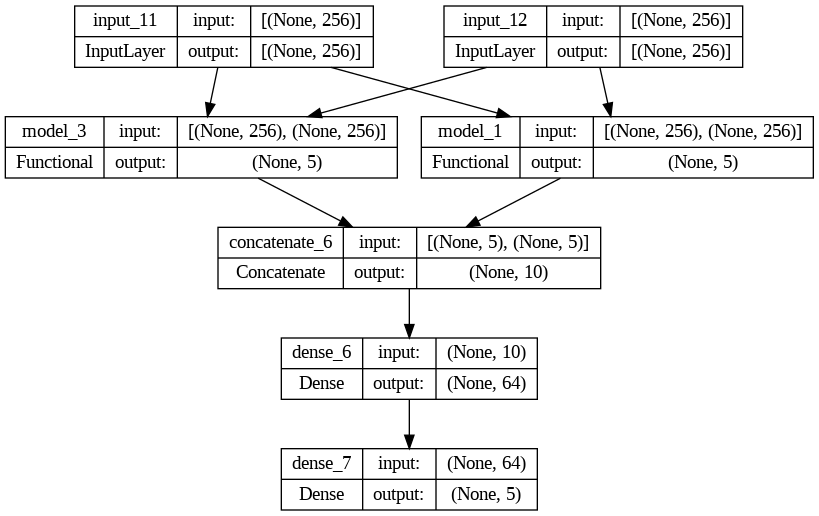

In [ ]:
from keras.utils import plot_model

plot_model(model_ensemble_bilstm_cnn, to_file='modelensembleCNNBilstm.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_ensemble_bilstm_cnn.save_weights('/content/drive/MyDrive/NCKHSV2023-2024/BiLSTM_CNN_text_classification.h5')

In [ ]:
history = model_ensemble_bilstm_cnn.fit(
    [np.array(train_title_ids), np.array(train_text_ids)],
    y_train,
    epochs=EPOCHS,
    batch_size=4,
    verbose=1,
    validation_data=([np.array(val_title_ids), np.array(val_text_ids)], y_val)
)

Epoch 1/20
1513/1513 [==============================] - 147s 90ms/step - loss: 0.1191 - accuracy: 0.9805 - val_loss: 1.0293 - val_accuracy: 0.7935
Epoch 2/20
1513/1513 [==============================] - 74s 49ms/step - loss: 0.0157 - accuracy: 0.9964 - val_loss: 1.3245 - val_accuracy: 0.7935
Epoch 3/20
1513/1513 [==============================] - 68s 45ms/step - loss: 0.0190 - accuracy: 0.9942 - val_loss: 1.3094 - val_accuracy: 0.7890
Epoch 4/20
1513/1513 [==============================] - 69s 46ms/step - loss: 0.0214 - accuracy: 0.9944 - val_loss: 1.2364 - val_accuracy: 0.7994
Epoch 5/20
1513/1513 [==============================] - 72s 47ms/step - loss: 0.0180 - accuracy: 0.9952 - val_loss: 1.2281 - val_accuracy: 0.7875
Epoch 6/20
1513/1513 [==============================] - 66s 43ms/step - loss: 0.0142 - accuracy: 0.9960 - val_loss: 1.3517 - val_accuracy: 0.7949
Epoch 7/20
1513/1513 [==============================] - 69s 45ms/step - loss: 0.0107 - accuracy: 0.9974 - val_loss: 1.4394 

In [ ]:
# Dự đoán trên tập validation
val_pred = model_ensemble_bilstm_cnn.predict([np.array(val_title_ids), np.array(val_text_ids)])

# Chuyển đổi dự đoán về dạng categorical
val_pred_categorical = np.argmax(val_pred, axis=1)

# Tính các metrics
report = classification_report(np.argmax(y_val, axis=1), val_pred_categorical)
print(report)


22/22 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.33      0.17      0.22         6
           1       0.15      0.25      0.19         8
           2       0.54      0.36      0.43        42
           3       0.46      0.47      0.47       107
           4       0.88      0.90      0.89       510

    accuracy                           0.79       673
   macro avg       0.47      0.43      0.44       673
weighted avg       0.78      0.79      0.78       673



***Evaluate on Test folder***

In [ ]:
# xây dựng hàm đánh giá
def test_BiLSTM_CNN(X_test, y_test):
    y_pred = model_ensemble_bilstm_cnn.predict(X_test)
    pred = np.argmax(y_pred,axis=1)

    print(classification_report(y_test, pred))

# đánh giá trên tập test
test_BiLSTM_CNN([np.array(test_title_ids), np.array(test_text_ids)], np.array(test_labels))

53/53 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.20      0.14      0.17        14
           1       0.48      0.50      0.49        24
           2       0.52      0.41      0.46        73
           3       0.51      0.51      0.51       280
           4       0.89      0.90      0.90      1290

    accuracy                           0.80      1681
   macro avg       0.52      0.49      0.50      1681
weighted avg       0.80      0.80      0.80      1681

